# Exposin Project State
The core features are done. Some optimizations and other interfaces may be explored later.
## Python Bindings
Classes representing the Lambert BVP for exposins and exposins themselves are exposed:

In [1]:
import PyKEP as pk
 
r1 = [149.0e9, 0.0, 0.0]
r2 = [300.0e9, -100.0e9, 0.0]
mu = 1.32e20
tof = 86400 * 550.0
lw = True
multirevs = -1 # signal automatic revolution detection
k2 = 0.2
 
prob = pk.lambert_exposin(r1, r2, tof, mu, lw, multirevs, k2)
exps = prob.get_exposins()

REPL functionality and some other readout functions are implemented:

In [2]:
print prob
isp = 5000
mass = 4000
print 'Exposin solutions:'
for ex in exps:
    print '-'
    print 'Mass: %.1f kg -> %.1f kg'            % (mass, ex.get_final_mass(mu, isp, mass))
    print 'Maximum thrust needed: %.3f N'       % ex.get_maximum_thrust(mu, isp, mass)
    print 'Revolutions: %i'                     % ex.get_revs()
    print 'Total angle traversed: %.1f degrees' % (ex.get_psi() * pk.RAD2DEG)

Lambert's problem (exponential sinusoid):
mu = 1.32e+20
r1 = [149000000000, 0, 0]
r2 = [300000000000, -100000000000, 0]
angle = 5.961435
time of flight: 4.752e+07
maximum number of revolutions: 3
solutions: 4
Rev := 0, v1 := [273.26732508160387, 30457.646163552894, 0], v2 := [10429.477629797388, 17740.436358328294, 0]
Rev := 1, v1 := [-8049.2550765341521, 29199.003864172912, 0], v2 := [12246.770756572079, 16432.140102360758, 0]
Rev := 2, v1 := [-8872.2667565589345, 28385.582678975705, 0], v2 := [11109.277684390094, 16791.273893726015, 0]
Rev := 3, v1 := [-9600.1019898287323, 27495.838017853152, 0], v2 := [9015.4286462301989, 17489.99803523767, 0]

Exposin solutions:
-
Mass: 4000.0 kg -> 3361.4 kg
Maximum thrust needed: 0.890 N
Revolutions: 0
Total angle traversed: 341.6 degrees
-
Mass: 4000.0 kg -> 2082.9 kg
Maximum thrust needed: 4.230 N
Revolutions: 1
Total angle traversed: 701.6 degrees
-
Mass: 4000.0 kg -> 842.8 kg
Maximum thrust needed: 16.055 N
Revolutions: 2
Total angle traverse

And graphing:

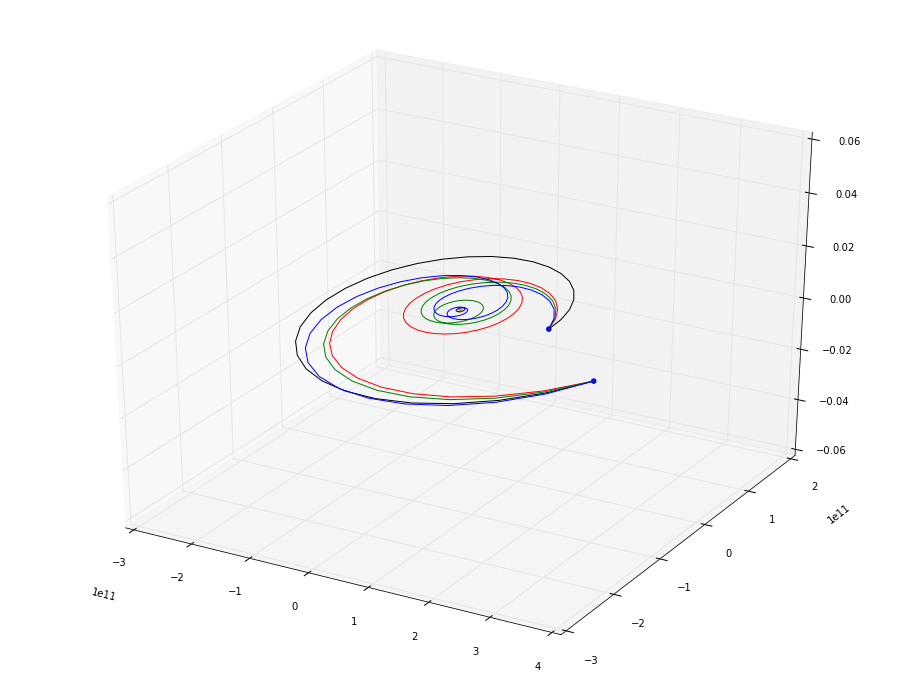

In [3]:
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 16, 12

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
axis = fig.gca(projection='3d')
 
axis.scatter([0],[0],[0],color='y')
axis.scatter([r1[0]],[r1[1]],[r1[2]],color='b')
axis.scatter([r2[0]],[r2[1]],[r2[2]],color='b')

for i in range(4):
    pk.orbit_plots.plot_lambert_exposin(prob,axis,sol=i,color=['k','r','g','b'][i])
 
plt.show()

Some solutions are clearly not useful!

In all, the Python bindings contain:

`lambert_exposin` object
* get_v1()
* get_v2()
* get_r1()
* get_r2()
* get_tof()
* get_mu()
* get_revs()
* get_exposins()

`exposin` object (no constructor)
* get_psi()
* get_revs()
* get_state()
* get_final_mass()
* get_maximum_thrust()


A graphing utility in `orbit_plots`

## C++ backend
* `lambert_exposin`, `class_exposin`, and `exposin` classes are implemented entirely within header files at the moment.

* `lambert_exposin` provides the solutions to a Lambert BVP.

* `class_exposin` handles the relevant exposin space for `lambert_exposin` and handles TOF searching - I do not think it is useful alone, so I did not create bindings.

* `exposin` represents a single exponential sinusoid trajectory. The C++ `exposin` class has some extra helper functions relating to its geometry that are left public but not exposed in Python (yet - I don't know if they will be needed).

A few tuning parameters are set at the top of each file. The notable one is that the TOF is limited to 100 years (assuming units = seconds) so that there are no floating point overflows in the TOF search. Regula Falsi convergence also becomes faster, as the very extreme sinusoid candidates are cut out. Other parameters are tolerances/iteration limits.

## Further work

Some optimization may be possible. The TOF evaluation for individual exposins and the TOF pruning process contribute to much of the solving time.

At the moment:

* The TOF quadrature is resolved using a simple mid-point integration rule. Interpolation may be explored to increase quality and/or decrease evaluation time.

* The solving exposins are found using Regula Falsi. It might be possible to switch to a Newton method using approximated derivatives.

Whether or not this is worth it is up for debate. It does not appear prohibitively slow, and is usually only an order of magnitude slower than the conic lambert solver:

In [5]:
setup = '''
import PyKEP as pk
r1 = [149.0e9, 0.0, 0.0]
r2 = [300.0e9, -100.0e9, 0.0]
mu = 1.32e20
tof = 86400 * 550.0
lw = True
N = 0
k2 = 0.2
'''
import timeit
t_exp = timeit.repeat("pk.lambert_exposin(r1,r2,tof,mu,lw,N,k2)", setup, number=500)
t_lam = timeit.repeat("pk.lambert_problem(r1,r2,tof,mu,lw,N)", setup, number=500)

print 'Time ratio: %.2fx' % (max(t_exp)/min(t_lam))

Time ratio: 53.71x


Code style changes and some better profiling are also good options.